# 3-SAT Problem Statement



A SAT (satisfiability) problem has as input a boolean expression in conjunctive normal form. In particular, the 3-SAT problem restricts the input to expressions where each clause has 3 literals.

Example:

F($x_1, x_2, x_3$) = ($x_1$ OR $x_2$ OR NOT($x_3$)) AND (NOT($x_1$) OR $x_2$ OR NOT($x_3$))

Possible solutions for this instance of a 3-SAT problem are: ($x_1, x_2, x_3$) $\in$ {(0, 0, 0), (0, 1, 0),..., (1, 1, 1)}. For example (0, 0, 1) is not a viable solution, because it does not respect the first clause: 0 OR 0 OR NOT(1) = 0 (false), and a false clause in an "AND" automatically leads to the final result of false.

We will now use Grover's algorithm to solve the "Exactly-One" variant of the 3-SAT problem quadratically faster than the classical algorithm. Let N be the number of all possible solutions. Then the classical algorithm requires O(N) iterations to try them all, whereas the quantum approach only needs O($\sqrt{N}$) iterations. The "Exactly-One" variation imposes only one restriction, that only one of the literals in each clause is true. So, for the example above, we cannot have $x_1$ true, $x_2$ true and $x_3$ false at the same time. Same applies to having $x_1$ false, $x_2$ true and $x_3$ false at the same time, in the case of the second clause.

## Importing the necessary libraries

In [1]:
# Uncomment the 2 lines below to install the libraries from the notebook, if necessary
!pip install qiskit
!pip install qiskit_aer
!pip install pylatexenc
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
%matplotlib inline

  Using cached rustworkx-0.16.0-cp39-abi3-macosx_11_0_arm64.whl.metadata (10 kB)
  Using cached stevedore-5.4.1-py3-none-any.whl.metadata (2.3 kB)
  Using cached pbr-6.1.1-py2.py3-none-any.whl.metadata (3.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 5.3 MB/s eta 0:00:0000:0100:01
Using cached rustworkx-0.16.0-cp39-abi3-macosx_11_0_arm64.whl (1.9 MB)
Using cached stevedore-5.4.1-py3-none-any.whl (49 kB)
Using cached pbr-6.1.1-py2.py3-none-any.whl (108 kB)
  Attempting uninstall: rustworkx
    Found existing installation: rustworkx 0.14.2
    Uninstalling rustworkx-0.14.2:
      Successfully uninstalled rustworkx-0.14.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 5.7 MB/s eta 0:00:0000:0100:01
  Using cached pylatexenc-2.10-py3-none-any.whl


## Step 0: Preparing the input

In [2]:
def input_state(circuit, circuit_input, circuit_output, n):
    """(n+1)-qubit input state for Grover search."""

    # With Hadamard gates on all input qubits, we create
    # an equal superposition of all possible solution states
    for j in range(n):
        circuit.h(circuit_input[j])

    # This is to initialize the ancillary qubit from |0> to |-> = (|0> - |1>)/ sqrt(2)
    circuit.x(circuit_output)
    circuit.h(circuit_output)

## Step 1: the Oracle

In [3]:
def oracle(circuit, circuit_input, circuit_output, aux, n, exactly_1_3_sat_formula):
    """
    Creates a circuit that verifies whether a given exactly-1 3-SAT
    formula is satisfied by the input circuit_input. The exactly-1 version
    requires exactly one literal out of every clause to be satisfied.
    """
    num_clauses = len(exactly_1_3_sat_formula)
    for (k, clause) in enumerate(exactly_1_3_sat_formula):
        # This loop ensures aux[k] is 1 if an odd number of literals
        # are true, where aux are the qubits that retain if each
        # clause is true or false
        for literal in clause:
            # if the literal is positive (not negated), it controls the
            # negation of the clause as it is
            if literal > 0:
                circuit.cx(circuit_input[literal-1], aux[k])
            else:
            # If the literal is negative (and thus negated -- e.g. NOT(a)), it has
            # to be first flipped by an x gate
                circuit.x(circuit_input[-literal-1])
                circuit.cx(circuit_input[-literal-1], aux[k])

        # Flip aux[k] if all literals are true, using auxiliary qubit
        # (ancilla) aux[num_clauses]
        circuit.ccx(circuit_input[0], circuit_input[1], aux[num_clauses])
        circuit.ccx(circuit_input[2], aux[num_clauses], aux[k])
        # Flip back to reverse state of negative literals and ancilla
        circuit.ccx(circuit_input[0], circuit_input[1], aux[num_clauses])
        for literal in clause:
            if literal < 0:
                circuit.x(circuit_input[-literal-1])

    # The formula is satisfied if and only if all auxiliary qubits
    # except aux[num_clauses] are 1
    if (num_clauses == 1):
        circuit.cx(aux[0], circuit_output[0])
    elif (num_clauses == 2):
        circuit.ccx(aux[0], aux[1], circuit_output[0])
    elif (num_clauses == 3):
        circuit.ccx(aux[0], aux[1], aux[num_clauses])
        circuit.ccx(aux[2], aux[num_clauses], circuit_output[0])
        circuit.ccx(aux[0], aux[1], aux[num_clauses])
    else:
        raise ValueError('We only allow at most 3 clauses')

    # Flip back any auxiliary qubits to make sure state is consistent
    # for the next iterations of the oracle + phase-amplification
    # stages of the circuit
    for (k, clause) in enumerate(exactly_1_3_sat_formula):
        for literal in clause:
            if literal > 0:
                circuit.cx(circuit_input[literal-1], aux[k])
            else:
                circuit.x(circuit_input[-literal-1])
                circuit.cx(circuit_input[-literal-1], aux[k])
        circuit.ccx(circuit_input[0], circuit_input[1], aux[num_clauses])
        circuit.ccx(circuit_input[2], aux[num_clauses], aux[k])
        circuit.ccx(circuit_input[0], circuit_input[1], aux[num_clauses])
        for literal in clause:
            if literal < 0:
                circuit.x(circuit_input[-literal-1])

In [4]:
# How does this oracle circuit look like?
n = 3
exactly_1_3_sat_formula = [[1, 2, -3], [-1, -2, -3], [-1, 2, 3]]
oracle_circuit = QuantumCircuit()
circuit_input = QuantumRegister(n)
circuit_output = QuantumRegister(1)
aux = QuantumRegister(len(exactly_1_3_sat_formula) + 1)
oracle_circuit.add_register(circuit_input)
oracle_circuit.add_register(circuit_output)
oracle_circuit.add_register(aux)

oracle(oracle_circuit, circuit_input, circuit_output, aux, n, exactly_1_3_sat_formula)

# How many gates are inside ?
print(oracle_circuit.count_ops())

# Let's see the circuit
print(oracle_circuit.draw())

OrderedDict([('ccx', 21), ('x', 20), ('cx', 18)])
                                         ┌───┐                              »
q0_0: ──■───────────────────■─────────■──┤ X ├───────■──────────────■───────»
        │                   │         │  ├───┤       │              │       »
q0_1: ──┼─────────■─────────■─────────■──┤ X ├───────┼────■─────────■───────»
        │  ┌───┐  │         │         │  ├───┤┌───┐  │    │         │       »
q0_2: ──┼──┤ X ├──┼────■────┼────■────┼──┤ X ├┤ X ├──┼────┼────■────┼────■──»
        │  └───┘  │    │    │    │    │  └───┘└───┘  │    │    │    │    │  »
  q1: ──┼─────────┼────┼────┼────┼────┼──────────────┼────┼────┼────┼────┼──»
      ┌─┴─┐     ┌─┴─┐┌─┴─┐  │  ┌─┴─┐  │              │    │    │    │    │  »
q2_0: ┤ X ├─────┤ X ├┤ X ├──┼──┤ X ├──┼──────────────┼────┼────┼────┼────┼──»
      └───┘     └───┘└───┘  │  └─┬─┘  │            ┌─┴─┐┌─┴─┐┌─┴─┐  │  ┌─┴─┐»
q2_1: ──────────────────────┼────┼────┼────────────┤ X ├┤ X ├┤ X ├──┼──┤ X ├»
              

## Step 2: the Phase Amplification

In [5]:
# We need the 2-controlled-Z gate to change the phase of the quantum state
# if it is a solution for our 3-SAT problem, which
# Qiskit does not yet offer
def n_controlled_Z(circuit, controls, target):
    if (len(controls) > 2):
        raise ValueError('The controlled Z with more than 2 ' +
                         'controls is not implemented')
    elif (len(controls) == 1):
        circuit.h(target)
        circuit.cx(controls[0], target)
        circuit.h(target)
    elif (len(controls) == 2):
        circuit.h(target)
        circuit.ccx(controls[0], controls[1], target)
        circuit.h(target)

def phase_amplification(circuit, circuit_input, n):
    # Hadamards everywhere
    for j in range(n):
        circuit.h(circuit_input[j])
    # D matrix: flips the sign of the state |000> only
    for j in range(n):
        circuit.x(circuit_input[j])
    n_controlled_Z(circuit, [circuit_input[j] for j in range(n-1)], circuit_input[n-1])
    for j in range(n):
        circuit.x(circuit_input[j])
    # Hadamards everywhere again
    for j in range(n):
        circuit.h(circuit_input[j])

In [6]:
# Let's see how the phase amplification circuit looks like
# for 3 qubits
n = 3
phase_amplification_circuit = QuantumCircuit()
circuit_input = QuantumRegister(n)
phase_amplification_circuit.add_register(circuit_input)
phase_amplification(phase_amplification_circuit, circuit_input, n)
phase_amplification_circuit.draw()

┌───┐┌───┐          ┌───┐┌───┐     
q3_0: ┤ H ├┤ X ├───────■──┤ X ├┤ H ├─────
      ├───┤├───┤       │  ├───┤├───┤     
q3_1: ┤ H ├┤ X ├───────■──┤ X ├┤ H ├─────
      ├───┤├───┤┌───┐┌─┴─┐├───┤├───┤┌───┐
q3_2: ┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├
      └───┘└───┘└───┘└───┘└───┘└───┘└───┘

## Finally: let's put it all together and solve the Exactly-One 3-SAT

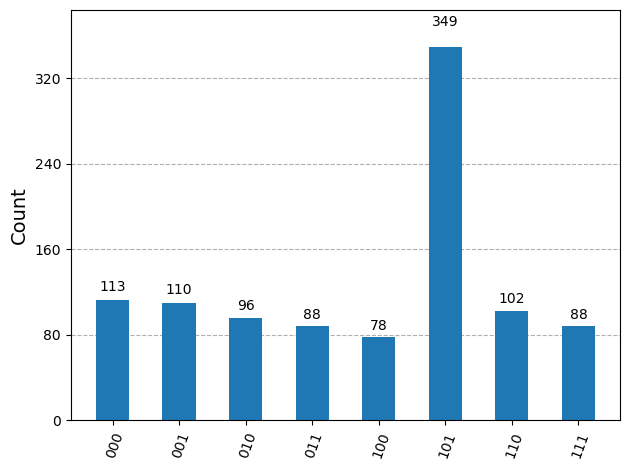

In [7]:
# Now w will make a quantum program for the n-bit Grover search.
# In this particular instance, we chose n=3 so we have 3 input variables
n = 3

# Only ONE literal is true in each clause
# Exactly-1 3-SAT formula to be satisfied, in conjunctive
# normal form. We represent literals with integers, positive or
# negative, to indicate a Boolean variable or its negation.
exactly_1_3_sat_formula = [[1, 2, -3], [-1, -2, -3], [-1, 2, 3]]

# Define three quantum registers: 'circuit_input' is the search space (input
# to the function f), 'circuit_output' is bit used for the output of function
# f, aux are the auxiliary bits used by f to perform its
# computation.
circuit_input = QuantumRegister(n)
circuit_output = QuantumRegister(1)
aux = QuantumRegister(len(exactly_1_3_sat_formula) + 1)

# Define classical register for algorithm result
ans = ClassicalRegister(n)

# Add to the quantum circuit the above quantum and classical registers
grover = QuantumCircuit()
grover.add_register(circuit_input)
grover.add_register(circuit_output)
grover.add_register(aux)
grover.add_register(ans)

# Prepare the input state for Grover search: the equal superposition
# and the |-> state
input_state(grover, circuit_input, circuit_output, n)

# Define how many iteration one uses
# Formula is T ~ O(sqrt(N/M)), where N is the number of all possible solutions
# and M is the number of actual solutions
# In our case, N = 2^3 = 8 and M = 1
T = 3 # Should be enough iterations to spot a solution
for t in range(T):
    # Apply T full iterations
    oracle(grover, circuit_input, circuit_output, aux, n, exactly_1_3_sat_formula)
    phase_amplification(grover, circuit_input, n)

# Measure the output register in the computational basis
for j in range(n):
    grover.measure(circuit_input[j], ans[j])

# Execute circuit
backend = AerSimulator()
circuit=transpile(grover, backend)
job = backend.run(circuit)
result = job.result()

# Get counts and plot histogram
counts = result.get_counts(circuit)
plot_histogram(counts)

## Let's see what the circuit and solution would look like for a more realistic problem.

In this example, there are 19 possible variables: $x_0$, $x_1$,...,$x_{18}$ -- not more because more than 24 qubits are not possible to have in the simulator.
We kept 3 clauses for practicality.

OrderedDict([('x', 5800), ('h', 3800), ('ccx', 2100), ('cx', 1800), ('measure', 19)])


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



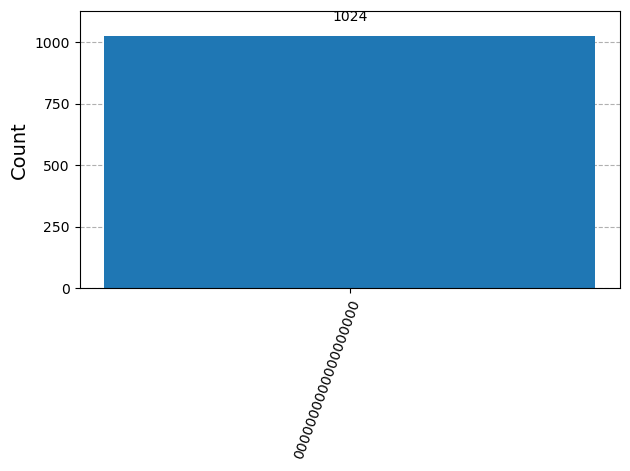

In [8]:
# Redefined the phase amplification, excluding the n-controlled-Z gate
def pseudo_phase_amplification(circuit, circuit_input, n):
    # Hadamards everywhere
    for j in range(n):
        circuit.h(circuit_input[j])
    # D matrix: flips the sign of the state |000> only
    for j in range(n):
        circuit.x(circuit_input[j])
    # n_controlled_Z(circuit, [circuit_input[j] for j in range(n-1)], circuit_input[n-1])
    for j in range(n):
        circuit.x(circuit_input[j])
    # Hadamards everywhere again
    for j in range(n):
        circuit.h(circuit_input[j])

# Let's see
n = 19

# Only ONE literal is true in each clause
# Exactly-1 3-SAT formula to be satisfied, in conjunctive
# normal form. We represent literals with integers, positive or
# negative, to indicate a Boolean variable or its negation.
exactly_1_3_sat_formula = [[1, 2, -3], [-1, -2, -3], [-1, 2, 3]]

# Define three quantum registers: 'circuit_input' is the search space (input
# to the function f), 'circuit_output' is bit used for the output of function
# f, aux are the auxiliary bits used by f to perform its
# computation.
circuit_input = QuantumRegister(n)
circuit_output = QuantumRegister(1)
aux = QuantumRegister(len(exactly_1_3_sat_formula) + 1)

# Define classical register for algorithm result
ans = ClassicalRegister(n)

# Add to the quantum circuit the above quantum and classical registers
grover = QuantumCircuit()
grover.add_register(circuit_input)
grover.add_register(circuit_output)
grover.add_register(aux)
grover.add_register(ans)

# Prepare the input state for Grover search: the equal superposition
# and the |-> state
# input_state(grover, circuit_input, circuit_output, n)
# skipped because it would be an 100-controlled z gate

# Define how many iteration one uses
# Formula is T ~ O(sqrt(N/M)), where N is the number of all possible solutions
# and M is the number of actual solutions
# In our case, N = 2^20 = 10^6. If the clause only has 1 solution,
# we could need a million times the oracle + phase circuit

T = 100 # Should be enough iterations to spot a solution
for t in range(T):
    # Apply T full iterations
    oracle(grover, circuit_input, circuit_output, aux, n, exactly_1_3_sat_formula)
    pseudo_phase_amplification(grover, circuit_input, n)

# Measure the output register in the computational basis
for j in range(n):
    grover.measure(circuit_input[j], ans[j])

print(grover.count_ops())

# Try to show your circuit
# (Will not work on google colab)
print(grover.draw())

# Try to execute the circuit
# Execute circuit
backend = AerSimulator()
circuit=transpile(grover, backend)
job = backend.run(circuit)
result = job.result()

# Get counts and plot histogram
counts = result.get_counts(grover)
plot_histogram(counts)

Solution above is taken from:
https://github.com/qiskit-community/qiskit-community-tutorials/blob/2a5559bbd1b98fee7cf316bfd2fa86e427a4ef5d/algorithms/grover_algorithm.ipynb,
which is the code basis of the following paper: https://arxiv.org/pdf/1708.03684.pdf .

Further Reading:
*   "Complete 3-Qubit Grover search on a programmable quantum computer": https://www.nature.com/articles/s41467-017-01904-7
*   A tutorial using Qiskit's out-of-the-box solution for the 3-SAT problem: https://github.com/Qiskit/qiskit-tutorials/blob/master/tutorials/algorithms/07_grover_examples.ipynb

Homework:
* Think how the circuit would look like to solve the general 3-SAT problem



